# ECE/CS 434 | MP3: AoA
<br />
<nav>
    <span class="alert alert-block alert-warning">Due March 28th 11:59PM 2021 on Gradescope</span> |
    <a href="https://www.gradescope.com/courses/223105">Gradescope</a> | 
    <a href="https://courses.grainger.illinois.edu/cs434/sp2021/">Course Website</a> | 
    <a href="http://piazza.com/illinois/spring2021/csece434">Piazza</a>
</nav><br> 

**Name(s):** _ , _<br>
**NetID(s):** _ , _

<hr />  

## Objective
In this MP, you will:
- Implement algorithms to find angle of arrivals of voices using recordings from microphone arrays.
- Perform triangulation over multiple AoAs to deduce user locations.
- Optimize voice localization algorithms using tools from probability theory, or signal processing.

---
## Imports & Setup
The following `code` cell, when run, imports the libraries you might need for this MP. Feel free to delete or import other commonly used libraries. Double check with the TA if you are unsure if a library is supported.

In [1]:
import numpy as np
import pandas as pd

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use("seaborn") # This sets the matplotlib color scheme to something more soothing
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

---
## Problem Description

Providing voice assistants with location information of the user can be helpful in resolving ambiguity in user commands. In this project, you will create a speaker localization algorithm using recordings from multiple voice assistant microphone arrays.

<figure>
<img src="images/scenario.png" alt="AoA Scenario" style="width: 500px;"/>
<figcaption>Figure 1: Application Scenario</figcaption>
</figure>

Consider the following scenario: there are eight voice assistants around the user. We will provide you with the location of these eight devices $L_{0}, L_{1}, \ldots, L_{7}$, their microphone array configuration, and the recordings from each of these devices $D_{0}, D_{1}, \ldots, D_{7}$. Your algorithm should take $D_{0}, D_{1}, \ldots D_{7}$ and $L_{0}, L_{1}, \ldots L_{7}$ as input and output the location of the user $L_{x}$.

You can tackle this problem by doing AoA on all eight devices and then use triangulation to find the user
location.

---
## Data Specification

Figure 3 shows the microphone array configuration. Each microphone array has 6 microphones indicated by green dots. They form a hexagon with mic #1 facing +x, mic #0 60 degrees counter-clockwise from mic #1, and so on. The diameter of the microphone array is $0.09218\text{ m}$(the distance between mic #0 and mic #3).  The sampling rate is $16000\text{ Hz}$.

Four sets of data can be found in `dataset#/`:
```
├── dataset0
│   ├── 0.csv
│   ├── 1.csv
│   ├── ...
│   ├── 7.csv
│   └── config.csv
├── dataset1
│   ├── ...
├── dataset2
│   ├── ...
└── dataset3
    ├── 0.csv
    ├── 1.csv
    ├── ...
    ├── 7.csv
    └── config.csv
    
```
In each directory, `0.csv` through `7.csv` contain data collected at each of the 8 microphone arrays. They each have 6 columns, corresponding to recorded samples from individual microphones on the mic array, with column number matching mic number. `config.csv` contains the microphone array coordinates. There are 8 comma-separated rows, corresponding to the (x, y) coodinates of the 8 microphone arrays. This is visualized in Figure 2 below. Note that the coordinates are in metres.

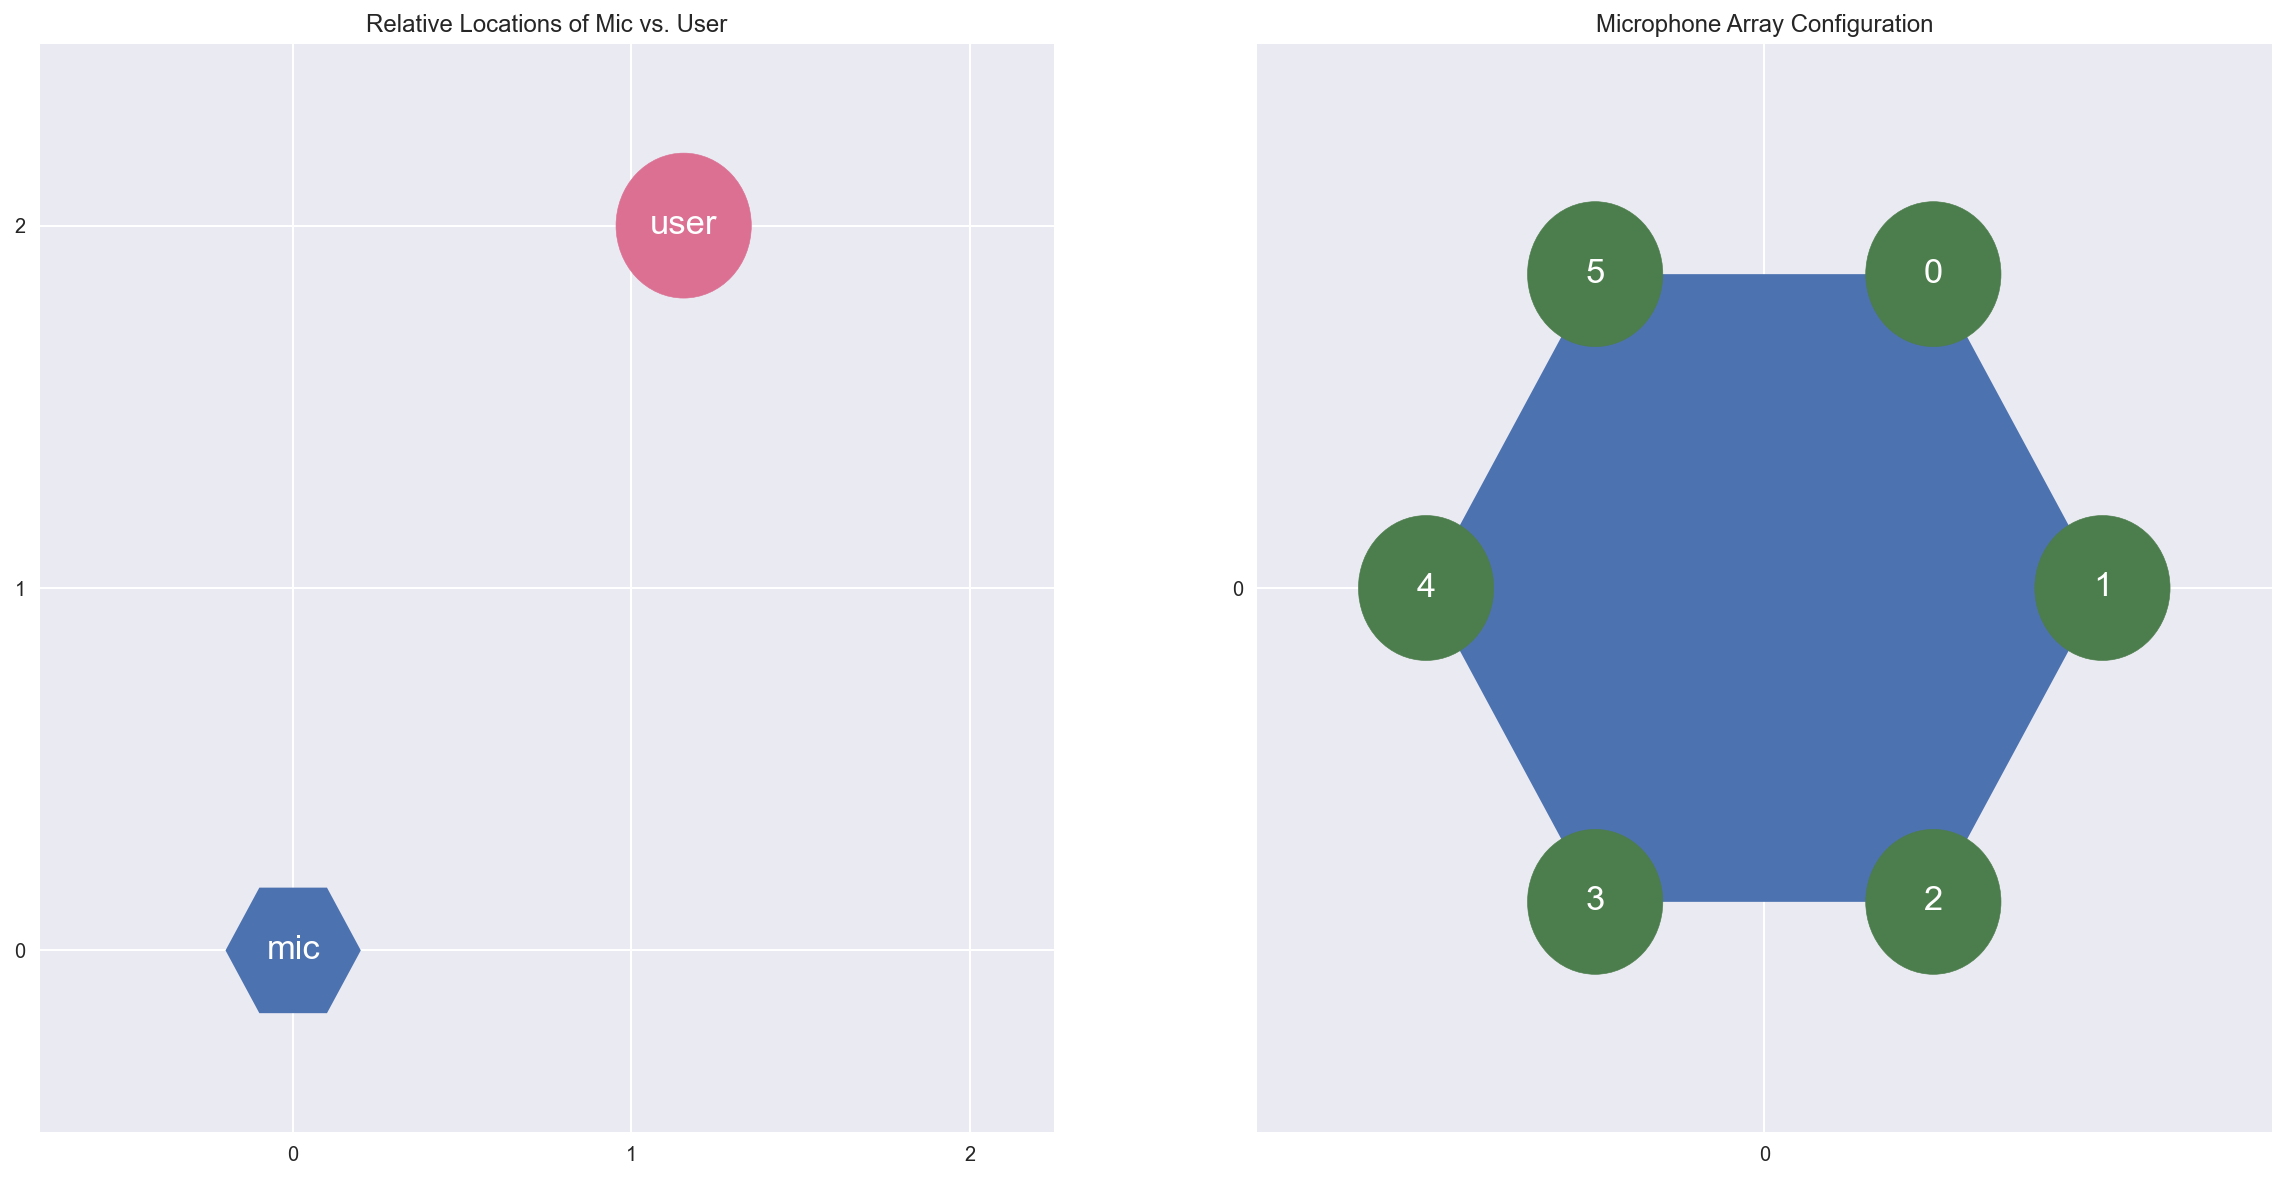

In [49]:
if __name__ == '__main__':
    array_locs = np.genfromtxt ('dataset0/config.csv', delimiter=",")
    user_1_location = np.array((3.0, 1.0))

    from matplotlib.patches import RegularPolygon, Circle
    fig, ax = plt.subplots(1, 2, figsize=(20,10), dpi=144)
    ax[0].set_title("Relative Locations of Mic vs. User")
    ax[0].grid(b=True, which="major", axis="both")
    ax[0].set_xlim((-0.75, 2.25))
    ax[0].set_xticks(np.arange(0, 3))
    ax[0].set_ylim((-0.5, 2.5))
    ax[0].set_yticks(np.arange(0, 3))
    loc_x, loc_y = 0, 0
    ax[0].add_patch(RegularPolygon(
        xy=(loc_x, loc_y), 
        numVertices=6, 
        radius=0.2, 
        orientation=np.pi/6
    ))
    ax[0].text(
        x=loc_x, 
        y=loc_y, 
        s="mic",
        color="white", 
        horizontalalignment="center",
        verticalalignment="center",
        fontsize="xx-large"
    )
    user_location = (2/1.732, 2)
    ax[0].add_patch(Circle(xy=user_location,radius=0.2, color="#DB7093"))
    ax[0].text(user_location[0], user_location[1], "user", color="white", ha="center", va="center", fontsize="xx-large")
    
    ax[1].set_title("Microphone Array Configuration")
    ax[1].grid(b=True, which="major", axis="both")
    ax[1].set_xlim((-0.75,0.75))
    ax[1].set_xticks([0])
    ax[1].set_ylim((-0.75,0.75))
    ax[1].set_yticks([0])
    ax[1].add_patch(RegularPolygon((0,0), 6, 0.5, np.pi/6))
    for mic_i in np.arange(6):
        mic_pos = np.e**(-1j * 2 * np.pi / 6 *  mic_i) \
            * np.e**(1j * 2 * np.pi / 6) * 0.5
        ax[1].add_patch(Circle(
            xy=(mic_pos.real, mic_pos.imag),
            radius=0.1, 
            color="#4c7d4c"
        ))
        ax[1].text(
            x=mic_pos.real, 
            y=mic_pos.imag, 
            s=mic_i,
            color="white", 
            horizontalalignment="center",
            verticalalignment="center",
            fontsize="xx-large"
        )
#     ax[1].annotate(
#         "",
#         xy=(0.42, -0.75),
#         xytext=(-0.42, 0.75),
#         arrowprops=dict(arrowstyle="|-|", color="white", lw=2)
#     )
#     ax[1].text(0.15, 0, "0.09218 m", color="white", ha="center")
    plt.show()

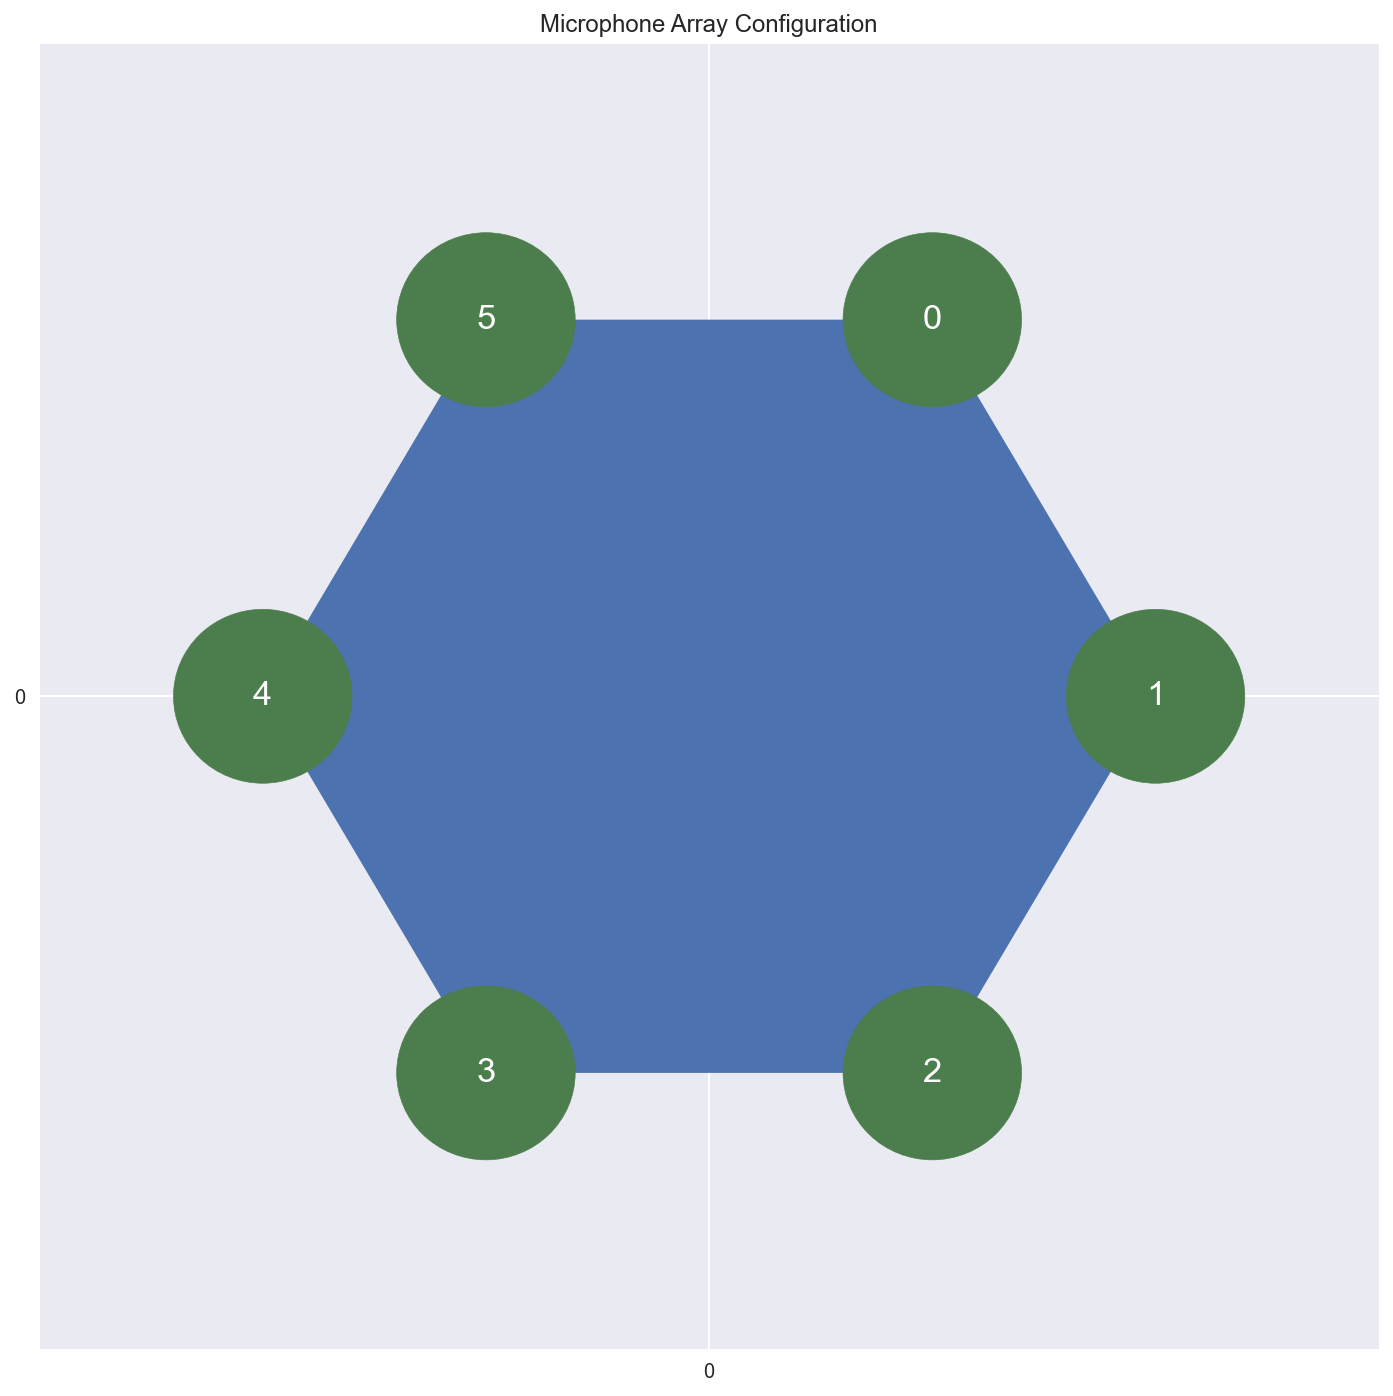

In [30]:
plt.figure(figsize=(12, 12), dpi=144)
ax = plt.gca()
ax.set_title("Microphone Array Configuration")
ax.grid(b=True, which="major", axis="both")
ax.set_xlim((-0.75,0.75))
ax.set_xticks([0])
ax.set_ylim((-0.75,0.75))
ax.set_yticks([0])
ax.add_patch(RegularPolygon((0,0), 6, 0.5, np.pi/6))
for mic_i in np.arange(6):
    mic_pos = np.e**(-1j * 2 * np.pi / 6 *  mic_i) \
        * np.e**(1j * 2 * np.pi / 6) * 0.5
    ax.add_patch(Circle(
        xy=(mic_pos.real, mic_pos.imag),
        radius=0.1, 
        color="#4c7d4c"
    ))
    ax.text(
        x=mic_pos.real, 
        y=mic_pos.imag, 
        s=mic_i,
        color="white", 
        horizontalalignment="center",
        verticalalignment="center",
        fontsize="xx-large"
    )
#     ax[1].annotate(
#         "",
#         xy=(0.42, -0.75),
#         xytext=(-0.42, 0.75),
#         arrowprops=dict(arrowstyle="|-|", color="white", lw=2)
#     )
#     ax[1].text(0.15, 0, "0.09218 m", color="white", ha="center")
plt.show()

---
## Your Implementation
Implement your localization algorithm in the function `aoa_localization(mic_data_folder, FS, MIC_OFFSETS)`. Do **NOT** change its function signature. You are, however, free to define and use helper functions. 

You are encouraged to inspect, analyze and optimize your implementation's intermediate results using plots and outputs. You may use the provided scratch notebook (`scratch.ipynb`) for this purpose, and then implement the relevant algorithm in the `aoa_localization` function (which will be used for grading). Your implementation for `aoa_localization` function should **NOT** output any plots or data. It should only return the user's calculated location.

In [3]:

def get_dataset(mic_data_folder):
    dataset = []
    for mic_num in np.arange(8):
        data = pd.read_csv(
            "{}/{}.csv".format(mic_data_folder, mic_num), 
            header=None
        )
        dataset.append(data.to_numpy())
    dataset = np.array(dataset)
    dataset = np.swapaxes(dataset, 1, 2)
    
    array_loc = np.genfromtxt(
        '{}/config.csv'.format(mic_data_folder), delimiter=","
    )
    array_loc = np.array(array_loc)
    return dataset, array_loc

def get_spectrum(mic_data_folder, FS, MIC_OFFSETS, grain=48):
    dataset, array_loc = get_dataset(mic_data_folder)
    
    AoA_spectrum = []
    for array in range(8):
        spectrum_per_array = []
        for theta_i in range(grain): #for every angle
            sample_offset= []

            theta = theta_i*360/grain

            hypt = 20 # hypotenuse = 20 meters
            adjc = hypt*np.cos(np.radians(theta)) # adjacent
            opps = hypt*np.sin(np.radians(theta)) # opposite

            mic_0_off_x, mic_0_off_y = MIC_OFFSETS[0]
            #print(xarray)

            mic_0_adjc = adjc - mic_0_off_x
            mic_0_opps = opps - mic_0_off_y
            mic_0_dist = np.sqrt(mic_0_adjc**2 + mic_0_opps**2) 

            for i in range(1, 6):
                mic_i_off_x, mic_i_off_y = MIC_OFFSETS[i]
                mic_i_adjc = adjc - mic_i_off_x
                mic_i_opps = opps - mic_i_off_y
                mic_i_dist = np.sqrt(mic_i_adjc**2 + mic_i_adjc**2)

                delta_dist = mic_i_dist - mic_0_dist 
                # d > 0 if mic_i farther than mic 0
                # d < 0 if mic_i closer than mic 0

                samples_delay = round((delta_dist*16000)/343)
    #                 print('Mic 0 vs Mic %d delay %d samples'%(i, samples_delay))
                sample_offset.append(samples_delay)

            crop_offset = 1000
            S0 = dataset[array, 0, crop_offset:-crop_offset]
    #             print('Shape of S0:', S0.shape)

            dot_product = S0
            for i in range(5):
                starting_sample = int(crop_offset + sample_offset[i])
                ending_sample = int(-crop_offset + sample_offset[i])
                S = dataset[array, i+1, starting_sample:ending_sample]
                dot_product = np.dot(dot_product, S)

            spectrum_per_array.append(dot_product)
        AoA_spectrum.append(spectrum_per_array)
    AoA_spectrum = np.array(AoA_spectrum)
#     print(AoA_spectrum.shape)
    return AoA_spectrum, array_loc

def triangle(AoA_spectrum, array_loc, grain=48):
    max_likelihood = 0
    max_x, max_y = 0, 0
    res = 2
    for j in range(res*5):
        for i in range(res*6):
            accumulated_likelihood = 0
            for array in range (8):
                mic_array_x, mic_array_y = array_loc[array, :]
                
                y = j/res
                x = i/res
                opps = y - mic_array_y
                adjc = x - mic_array_x + 0.00001
                tan = opps/adjc
                angle_in_radians = np.arctan(tan)
                
                angle = round(np.degrees(angle_in_radians))
                
                if adjc < 0:
                    angle += 180
                elif opps < 0:
                    angle += 360
                angle = round(angle/(360/grain))
                if angle == grain:
                    angle = 0
#                 print(mic_array_x, mic_array_y, x, y, angle)
                accumulated_likelihood += AoA_spectrum[array][int(angle)]
             
            if accumulated_likelihood > max_likelihood:
                max_likelihood = accumulated_likelihood
                max_x = x
                max_y = y
    return max_x, max_y

In [4]:
def aoa_localization(mic_data_folder, FS, MIC_OFFSETS):
    """AoA localization algorithm. Write your code here.

    Args:
        mic_data_folder: name of folder (without a trailing slash) containing 
                         the mic datafiles `0.csv` through `7.csv` and `config.csv`.
        FS: microphone sampling frequency - 16kHz.
        MIC_OFFSETS: a list of tuples of each microphone's location relative to the center of its mic array. 
                     This list is calculated based on the diameter(0.09218m) and geometry of the microphone array.
                     For example, MIC_OFFSETS[1] is [0.09218*0.5, 0]. If the location of microphone array #i is
                     [x_i, y_i]. Then [x_i, y_i] + MIC_OFFSETS[j] yields the absolute location of mic#j of array#i.
                     This is provided for your convenience and you may choose to ignore.

    Returns:
        The user's location in this format (in metres): (L_x, L_y)

    """

    # Your return value should be the user's location in this format (in metres): (L_x, L_y)
    total_spectrums, array_loc =get_spectrum(mic_data_folder, FS, MIC_OFFSETS)
    userx, usery = triangle(total_spectrums, array_loc)
    return (userx, usery)

---
## Running and Testing
Use the cell below to run and test your code, and to get an estimate of your grade.

In [5]:
def calculate_score(calculated, expected):
    calculated = np.array(calculated)
    expected = np.array(expected)
    distance = np.linalg.norm(calculated - expected, ord=2)
    score = max(1 - (distance-1)/3, 0)
    return min(score, 1)

if __name__ == '__main__':
    test_folder_user_1 = 'user1_data'
    test_folder_user_2 = 'user2_data'
    groundtruth = [(3.0, 1.0), (4.0, 1.0), (3.0, 1.0), (4.0, 1.0)]
    MIC_OFFSETS = [(0.023,0.0399), (0.0461,0), (0.0230,-0.0399), (-0.0230,-0.0399), (-0.0461,0), (-0.0230,0.0399)]
    FS = 16000 # sampling frequency
    
    output = [['Dataset', 'Expected Output', 'Your Output', 'Grade', 'Points Awarded']]
    for i in range(4):
        directory_name = 'dataset{}'.format(i)
        student_loc = aoa_localization(directory_name, FS, MIC_OFFSETS)
        score = calculate_score(student_loc, groundtruth[i])    
        output.append([
            str(i),
            str(groundtruth[i]), 
            str(student_loc), 
            "{:2.2f}%".format(score * 100),
            "{:1.2f} / 5.0".format(score * 5),
        ])

    output.append([
        '<i>👻 Hidden test 1 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    output.append([
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        '<i>...</i>', 
        "<i>...</i>"])
    output.append([
        '<i>👻 Hidden test 6 👻</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        '<i>???</i>', 
        "<i>???</i> / 10.0"])
    display_table(output)

---
## Rubric
You will be graded on the four datasets provided to you (5 points each) and six additional datasets under different settings(10 points each). Make sure you are not over-fitting to the provided data. We will use the same code from the **Running and Testing** section above to grade all 10 traces of data. You will be graded on the distance between your calculated user location and ground truth. An error of upto $1 \text{ m}$ is tolerated (and still awarded 100% of the grade). An error of $4 \text{ m}$ or above will be awarded a 0 grade. Grades for errors between $1 \text{ m}$ and $4 \text{ m}$ will be scaled proportionally.

---
## Submission Guidlines
This Jupyter notebook (`MP3.ipynb`) is the only file you need to submit on Gradescope. As mentioned earlier, you will only be graded using your implementation of the `aoa_localization` function, which should only return the calculated **NOT** output any plots or data. If you are working in a pair, make sure your partner is correctly added on Gradescope and that both of your names are filled in at the top of this file.

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**